# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


# f'20210209-0234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=7 res=456'

# 8

In [2]:
EPOCH_TO_LOAD = 7

RUN_NAME_OF_MODEL_TO_LOAD = '20210215-0355 - arch=<function xse_resnext34 at 0x7f6ed4c51d30> - samples=1800 frozen=1 epochs=60 bs=32 res=250'

<br>
<br>

In [3]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F


%matplotlib inline

# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')


ARCH = xse_resnext34  #'efficientnet_b3a'  # resnet101

CHOSEN_SAMPLE_SIZE = 800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
# TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.1)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 60  # 4
BATCH_SIZE = 16  # 14  # 16
# RESOLUTION = round(380 * 1.2)  # 300
RESOLUTION=400 # 420
PRETRAINED_FLAG = True

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

# RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'
RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")


RUN_NAME = '20210220-2303 - arch=<function xse_resnext34 at 0x7fb81dbce3a0> - samples=800 frozen=1 epochs=60 bs=16 res=400'


In [4]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

## Utility Functions to use timm models on FastAI

written by Zach Mueller / walkwithfastai.com



In [5]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=False, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model


def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

## More by zach via Abhishek Tez - augmentations 

In [6]:
import albumentations

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
    
def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(256,256),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])



def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(256,256, p=1.),
    albumentations.Resize(256,256)
], p=1.)


<br>
<br>

### Add a Module for Gradient Checkpointing

In [7]:


from torch.utils.checkpoint import checkpoint, checkpoint_sequential

class CheckpointModule(Module):
    def __init__(self, module, num_segments=1):
        assert num_segments == 1 or isinstance(module, nn.Sequential)
        self.module = module
        self.num_segments = num_segments

    def forward(self, *inputs):
        if self.num_segments > 1:
            return checkpoint_sequential(self.module, self.num_segments, *inputs)
        else:
            return checkpoint(self.module, *inputs)

        

# To extract the sequential layers from resnet
def layer_config(arch):
    "Get the layers associated with `arch`."
    return model_layers.get(arch)


model_layers = {
    resnet18 :[2, 2, 2, 2], resnet34: [3, 4, 6, 3],
    resnet50 :[3, 4, 6, 3], resnet101:[3, 4, 23, 3],
    resnet152:[3, 8, 36, 3]}


def convert_seq_chkpt(model, layer_type_old):  #, num_chkpt):
#     seg_dict = {2:2, 3:6, 4:5, 5:5, 6:3, 7:3, 8:2, 1:1}
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_seq_chkpt(module, layer_type_old) #, num_chkpt+1)

        if type(module) == layer_type_old:
#             num_chkpt += 1
            layer_old = module
            if len(layer_old) == 7:
                segments = 1
            else: segments = len(layer_old)
            layer_new = CheckpointModule(layer_old, segments)  # wrap sequential in a checkpoint module
            model._modules[name] = layer_new
#             print(num_chkpt)  # 2,3,4,5,6,7,8,1
#             print(len(layer_old))

    return model

## Memory efficient implementation of Swish and Mish from Ross Wightman

In [8]:
class SwishAutoFn(torch.autograd.Function):
    """Swish - Described in: https://arxiv.org/abs/1710.05941
    Memory efficient variant from:
     https://medium.com/the-artificial-impostor/more-memory-efficient-swish-activation-function-e07c22c12a76
    """
    @staticmethod
    def forward(ctx, x):
        result = x.mul(torch.sigmoid(x))
        ctx.save_for_backward(x)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        return grad_output.mul(x_sigmoid * (1 + x * (1 - x_sigmoid)))


def swish_auto(x, inplace=False):
    # inplace ignored
    return SwishAutoFn.apply(x)


class SwishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(SwishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return SwishAutoFn.apply(x)




class MishAutoFn(torch.autograd.Function):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function - https://arxiv.org/abs/1908.08681
    Experimental memory-efficient variant
    """

    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        y = x.mul(torch.tanh(F.softplus(x)))  # x * tanh(ln(1 + exp(x)))
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        x_tanh_sp = F.softplus(x).tanh()
        return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


def mish_auto(x, inplace=False):
    # inplace ignored
    return MishAutoFn.apply(x)


class MishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(MishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishAutoFn.apply(x)

In [9]:
def fit_hump(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    
    
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    
    f = combine_scheds([0.1,0.1, 0.05, 0.05,0.2, 0.5], 
                   [SchedCos(lr_max*0.8,lr_max*1.0), 
                    SchedLin(lr_max*1.0,lr_max*1.0), 
                    SchedCos(lr_max*1.0, lr_max*0.75), 
                    SchedCos(lr_max*0.75, lr_max*0.95), 
                    SchedCos(lr_max*0.95,lr_max*0.9), 
                    SchedCos(lr_max*0.9,lr_max/div_final)])
    
    scheds = {'lr': f,
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

In [10]:
def fit_slide(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    
    
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    
#     f = combine_scheds([0.1,0.1, 0.05, 0.05,0.2, 0.5], 
#                    [SchedCos(lr_max*0.8,lr_max*1.0), 
#                     SchedLin(lr_max*1.0,lr_max*1.0), 
#                     SchedCos(lr_max*1.0, lr_max*0.75), 
#                     SchedCos(lr_max*0.75, lr_max*0.95), 
#                     SchedCos(lr_max*0.95,lr_max*0.9), 
#                     SchedCos(lr_max*0.9,lr_max/div_final)])
    
    f = combine_scheds([1], [SchedLin(lr_max*1.0, lr_max/div_final)])
    
    scheds = {'lr': f}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

<br>
<br>

### Check for Imbalance

In [11]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

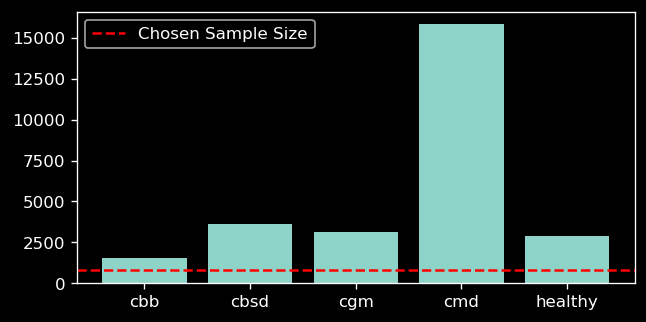

In [12]:
path = '../data/train_images_sorted_extra'

img_flist = {}
img_quants = {}

for c in classes:
    files = get_image_files(f'{path}/{c}')
    img_flist[c] = list(files)
    img_quants[c] = len(files)

minqc = min(img_quants, key=img_quants.get)

# sample_size = round(img_quants[minqc] * 2.5)  # oversample the lowest class quantity
sample_size = CHOSEN_SAMPLE_SIZE

plt.figure(figsize=(6,3))
plt.bar(img_quants.keys(), img_quants.values())  
plt.axhline(sample_size, ls='--', color='red', label='Chosen Sample Size')
plt.legend()
plt.show()
        

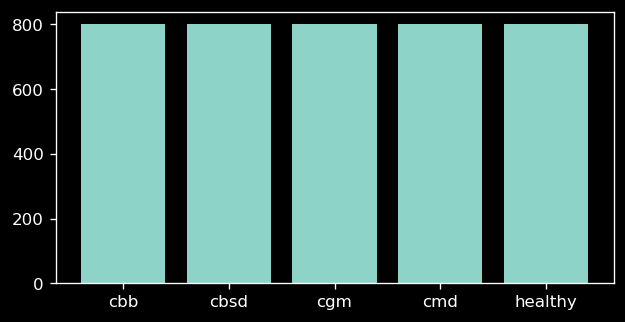

In [13]:

for c in classes:
    if len(img_flist[c]) < sample_size:
#         all_covid = img_flist[c].copy()
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], sample_size - len(img_flist[c]), replace=True))
    else:
        img_flist[c] = np.random.choice(img_flist[c], sample_size, replace=False)  # without replacement

    # boost the weak class
#     if c == 'healthy':
#         img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], round(sample_size * 0.5), replace=False))
        
plt.figure(figsize=(6,3))
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.show()

In [14]:
test_flist = {}
test_size = round(0.1 * sample_size)

for c in classes:
    img_flist[c] = np.random.choice(img_flist[c], len(img_flist[c]), replace=False)  # shuffle
    test_flist[c] = img_flist[c][0:test_size]
    img_flist[c] = img_flist[c][test_size:]
#     img_flist[c] = [f for f in img_flist[c] if f not in test_flist[c]]

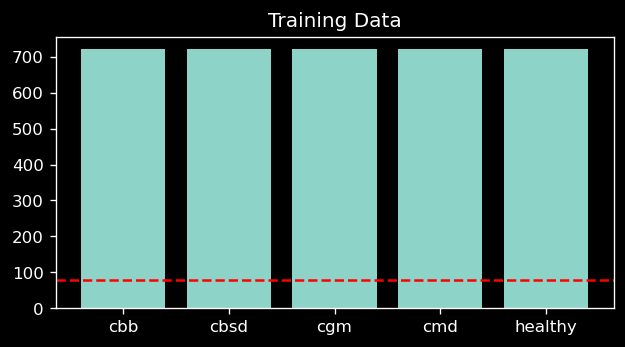

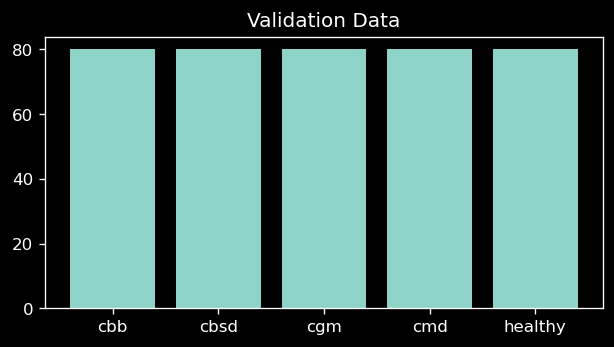

In [15]:
plt.figure(figsize=(6,3))
plt.title('Training Data')
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.axhline(test_size, ls='--', color='red')
plt.show()

plt.figure(figsize=(6,3))
plt.title('Validation Data')
plt.bar(test_flist.keys(), [len(l) for l in test_flist.values()])
plt.show()
                 

In [16]:
def get_fnames(path):
    retlist = []
    
    for l in img_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))


item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())


# batch_tfms = [ *aug_transforms(size=round(RESOLUTION * 1), do_flip=True, batch=True, max_zoom=1.7, mult=2.4), Normalize.from_stats(*imagenet_stats) ]
# batch_tfms = [ *aug_transforms(size=RESOLUTION, do_flip=True, batch=False, max_lighting=0.7,
#                                max_rotate=30, max_zoom=2.5, mult=2.0, max_warp=0.1), 
#               Normalize.from_stats(*imagenet_stats) ]

batch_tfms = [Normalize.from_stats(*imagenet_stats)]


img_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.28, seed=42),
    get_y=parent_label,
#     item_tfms=RandomResizedCrop(RESOLUTION, method='bilinear') , batch_tfms=batch_tfms)
    item_tfms=item_tfms , batch_tfms=batch_tfms)

dls = img_db.dataloaders(path, batch_size=BATCH_SIZE)

<br>

### Verify the Training and Validation Batches

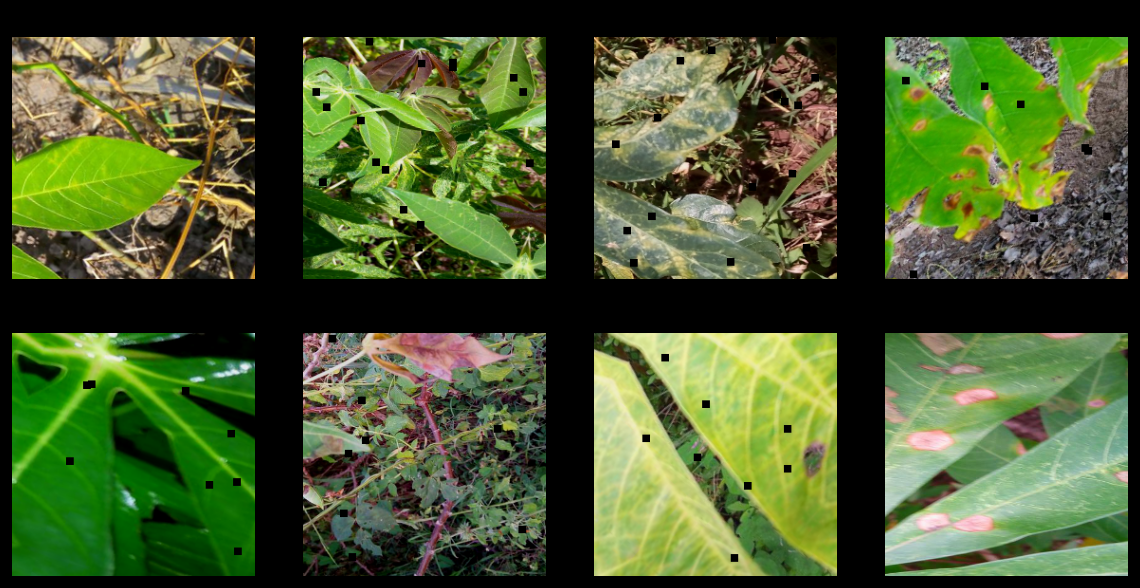

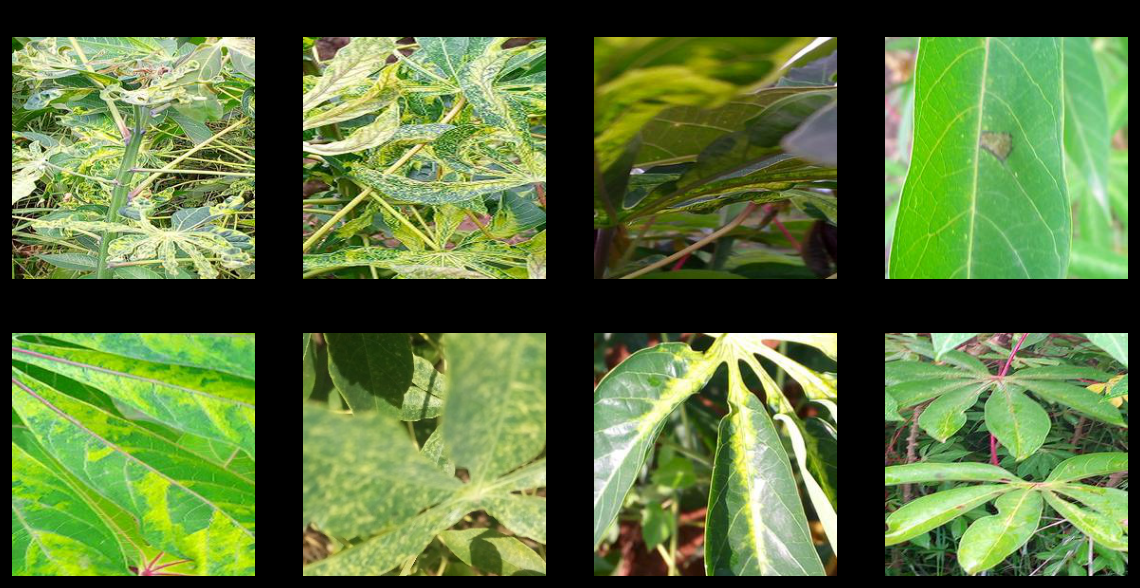

In [17]:
dls.train.show_batch(max_n=8, nrows=2)
dls.valid.show_batch(max_n=8, nrows=2)

In [18]:
# Eary stopping callback
early_stop_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=5)

# Save the current model's weights every epoch
save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True)

# Reduce the Learning Rate if valid_loss flatlines
reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=2, factor=15, reset_on_fit=True)

# Mixup callback for regularization
# mixup_cb = MixUp(alpha=0.4)
mixup_cb = None

# Cutmix callback for regularization
cutmix_cb = CutMix(alpha=0.50)
# cutmix_cb = None

# Gradient Accumulation
# gradacc_cb =  GradientAccumulation(n_acc=16)
gradacc_cb =  GradientAccumulation(n_acc=128)


# List of callbacks to be used later
cbs = [ShowGraphCallback(), save_cb, GradientClip , gradacc_cb] # , reduceLR_cb

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)




print('\nAll Callbacks: ', cbs)


All Callbacks:  [CutMix, ShowGraphCallback, SaveModelCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation]


### Visualize the effect of CutMix


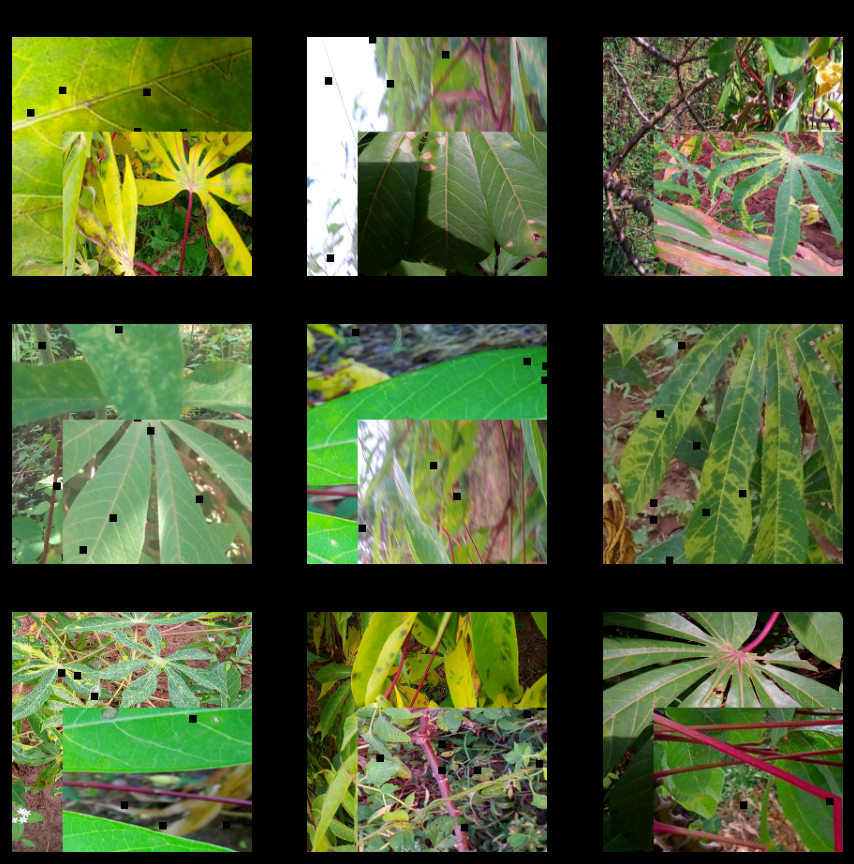

In [19]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [20]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


In [21]:
ARCH = xse_resnext34(pretrained=True, act_cls=MishAuto, sa=True)

learn = Learner(dls, ARCH, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropyFlat(), 
                    cbs = cbs, metrics=[accuracy])

# from wwf.vision.timm import *
# import timm
# learn = timm_learner(dls, 
#                     'efficientnet_b3a',
#                      opt_func=ranger,
#                      loss_func=LabelSmoothingCrossEntropyFlat(),
#                      cbs=cbs, pretrained=True,
#                      metrics = [accuracy]).to_fp16()



In [22]:
# Add custom weights to learn

# learn = load_learner(f'../models/{RUN_NAME_OF_MODEL_TO_LOAD}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # doesn't exist!
learn.model = convert_act_cls(learn.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the last layers
learn.model = convert_act_cls(learn.model, nn.SiLU, SwishAuto())  # replace with a lower memory version


# learn.model[0] = convert_seq_chkpt(learn.model[0], nn.Sequential) #, 0)  # wrap all BODY sequentials to use Gradient Checkpointing
# learn.model[0] = nn.Sequential(CheckpointModule(learn.model[0]))  # hack in the final checkpointmodule for the base sequence

# learn = learn.to_fp16()  # convert to 16bit

In [23]:
display(learn.loss_func, learn.opt_func, learn.cbs)  #, '-------------------------------------', learn.model)  # Checkpoint

FlattenedLoss of LabelSmoothingCrossEntropy()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

(#8) [TrainEvalCallback,Recorder,ProgressCallback,CutMix,ShowGraphCallback,SaveModelCallback,GradientClip,GradientAccumulation]

In [24]:

# RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/20210214-0034 - arch=<function xse_resnext34 at 0x7f469d40be50> - samples=1800 frozen=1 epochs=60 bs=14 res=420_0.pth', learn, opt=ranger, with_opt=False)
# load_model(f'models/20210214-0137 - arch=<function xse_resnext34 at 0x7f2f532391f0> - samples=1800 frozen=1 epochs=60 bs=14 res=420_14.pth', learn, opt=ranger, with_opt=False)
# load_model(f'models/20210214-0644 - arch=<function xse_resnext34 at 0x7f2f532391f0> - samples=1800 frozen=1 epochs=60 bs=14 res=420_14.pth', learn, opt=ranger, with_opt=False)


<br>
<br>
<br>
<br>

# ------------------ RUN TO HERE -------------------

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [25]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [26]:
# learn = learn.to_fp16()

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


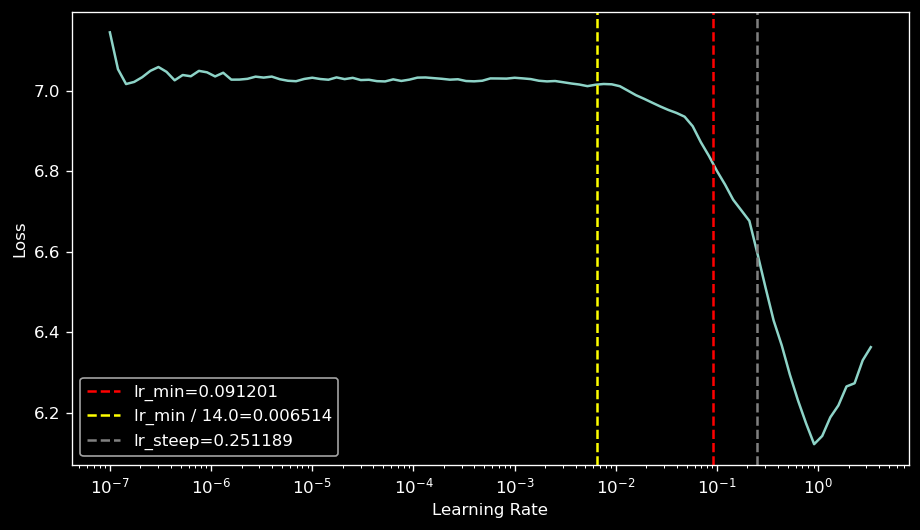

Minimum/10: 9.12e-02, steepest point: 2.51e-01, (Mim/10)/14.0: 0.006514363203729902


In [27]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [28]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
# LR_CHOICE = 8e-5
# LR_CHOICE = 2e-4
# LR_CHOICE = 7e-2
LR_CHOICE=1e-1

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [29]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

FROZEN_EPOCHS:  1
EPOCHS:         60
Learning Rate:  0.1




Better model found at epoch 0 with valid_loss value: 2.5252654552459717.


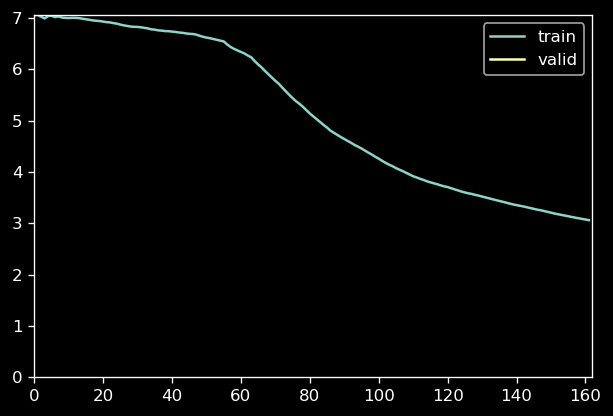

Max GPU Memory Allocated: 2.563344896 GB


/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [30]:
if PRETRAINED_FLAG:
    learn.freeze()
#     learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)
    fit_hump(learn, FROZEN_EPOCHS, lr_max=lr_min)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

## Manually set up the unfrozen runs

In [31]:
learn.unfreeze()

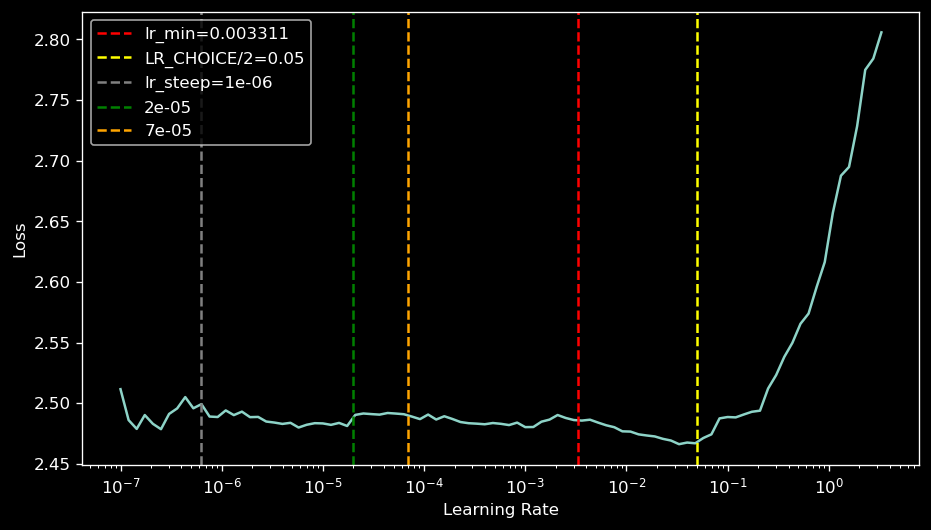

In [32]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")  # , LR_CHOICE/2: {LR_CHOICE / 2}")

## Pick a new Learning Rate

In [33]:
# LR_CHOICE_UNFROZ = lr_min/LR_DIV
# LR_CHOICE_UNFROZ = LR_CHOICE / 2
# LR_CHOICE_UNFROZ = 0.00015
# LR_CHOICE_UNFROZ = 10e-5
# LR_CHOICE_UNFROZ = 0.00008
# LR_CHOICE_UNFROZ = 5.5e-5
# LR_CHOICE_UNFROZ = 1.7e-4
# LR_CHOICE_UNFROZ = 6e-5
LR_CHOICE_UNFROZ = lr_min
# LR_CHOICE_UNFROZ = 1e-3
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = lr_steep
# LR_CHOICE_UNFROZ = 0.007

### Train

In [35]:
EPOCHS = 5

In [36]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         5
Learning Rate:  0.0033113110810518267




Better model found at epoch 0 with valid_loss value: 2.375734567642212.


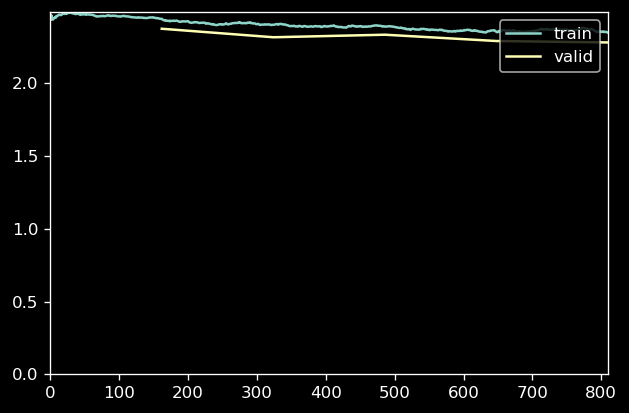

Better model found at epoch 1 with valid_loss value: 2.317230224609375.
Better model found at epoch 3 with valid_loss value: 2.291349411010742.
Better model found at epoch 4 with valid_loss value: 2.2814931869506836.
Max GPU Memory Allocated: 2.562820608 GB


In [37]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)
# learn.fit_one_cycle(1, LR_CHOICE_UNFROZ, pct_start=0.4, wd=1e-2)
learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.7, wd=1e-2)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

In [ ]:
learn.recorder.plot_sched()

<br>
<br>

<br>
<br>

<br>

# -------------------- TRAIN AGAIN -----------------

<br>

<br>
<br>

### Train again

In [25]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD

# RUN_NAME_OF_MODEL_TO_LOAD = '20210214-1340 - arch=<function xse_resnext34 at 0x7fed41524d30> - samples=1800 frozen=1 epochs=60 bs=14 res=420'
# EPOCH_TO_LOAD = 15

# learn = load_learner(f'../models/{RUN_NAME_OF_MODEL_TO_LOAD}.pkl', cpu=False)

load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_9.pth', learn, opt=ranger, with_opt=False)

In [26]:
learn.unfreeze()

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


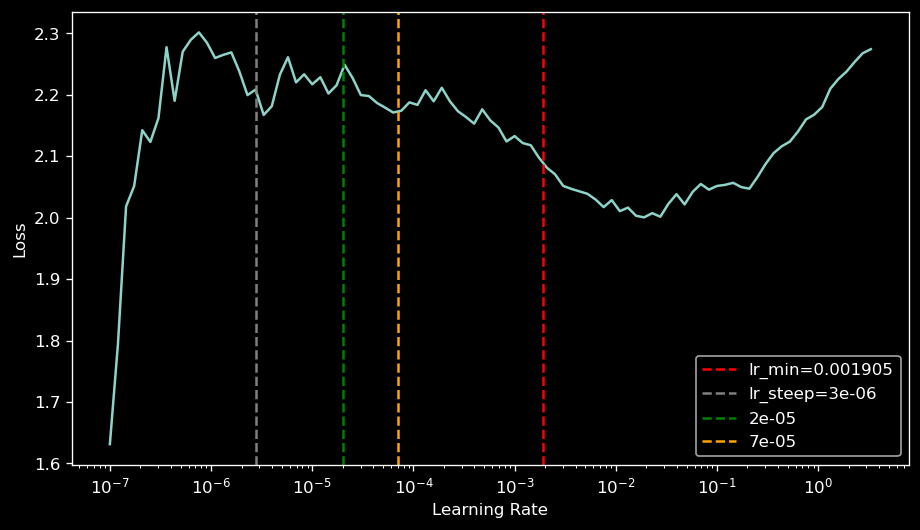

In [53]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [30]:
EPOCHS = 48
LR_CHOICE_UNFROZ = 8e-3

In [31]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         48
Learning Rate:  0.008




Better model found at epoch 0 with valid_loss value: 1.655868411064148.


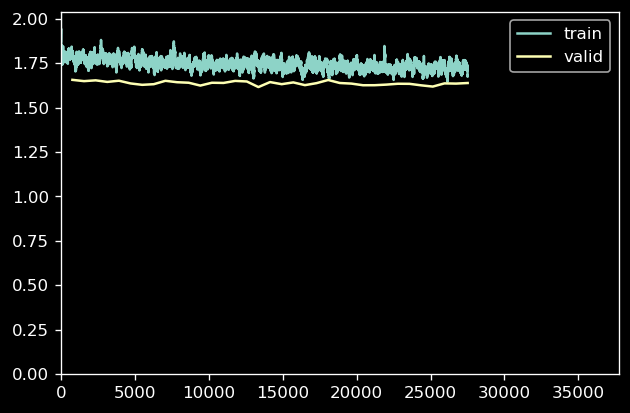

Better model found at epoch 1 with valid_loss value: 1.648668646812439.
Better model found at epoch 3 with valid_loss value: 1.6443427801132202.
Better model found at epoch 5 with valid_loss value: 1.6357265710830688.
Better model found at epoch 6 with valid_loss value: 1.6279250383377075.
Better model found at epoch 11 with valid_loss value: 1.6237274408340454.
Better model found at epoch 16 with valid_loss value: 1.615310549736023.


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.79 GiB total capacity; 4.80 GiB already allocated; 214.44 MiB free; 5.30 GiB reserved in total by PyTorch)

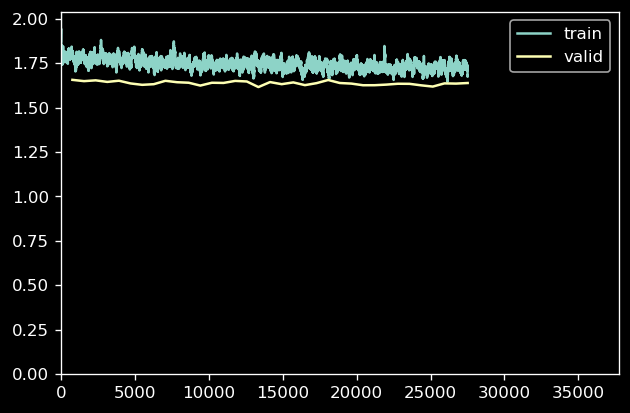

In [32]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.1, wd=0.1, reset_opt=True)
#fit_slide(learn, EPOCHS, 1e-2, reset_opt=True)
print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()

<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

<br>
<br>
<br>
<br>

# ----------------- Validation ------------

<br>
<br>
<br>

## Validation

In [ ]:
test_learn = learn

# load_learner('../models/20210205-1716 - arch=xresnet34 - samples=1800 frozen=1 epochs=40 bs=32 res=340.pkl', cpu=False)
# load_model(f'models/{RUN_NAME}_26.pth', test_learn, opt=Adam, with_opt=False)


In [ ]:
def get_test_fnames(path):
    retlist = []
    
    for l in test_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=Resize(RESOLUTION, method='bilinear', pad_mode='zeros'), batch_tfms=batch_tfms) #,
#     item_tfms=CropPad(RESOLUTION, pad_mode='zeros'))
#    ,    batch_tfms=aug_transforms(do_flip=True, size=RESOLUTION, batch=False, max_zoom=1.0, mult=1, pad_mode='zeros'))


dls = test_db.dataloaders(get_test_fnames, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
# !sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('EFB4 Cassava Disease Classification-Copy2.ipynb', f'.Archive/{time} - EFB4 Cassava Disease Classification-Copy2.ipynb')

## Infer on the Kaggle provided test set